In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST('./data', train=True, transform=trans, download=True)
test_set = dset.MNIST('./data', train=False, transform=trans, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [5]:
n1 = 28*28
n2 = 100
n3 = 40
n4 = 10

k1 = torch.FloatTensor([0.63576])
k2 = torch.FloatTensor([1.87320])
k3 = torch.FloatTensor([1.48695])

def kl(log_sigma_2, theta):
    log_alpha = log_sigma_2 - torch.log(theta.pow(2))
    log_alpha = log_alpha.clamp(-8,8)
    return (k1*torch.sigmoid(k2 + k3*log_alpha) - 0.5*torch.log1p(log_alpha.neg().exp()) - k1).sum()

def rand_W(n_in, n_out):
    return rnd.randn(n_in, n_out)

def rand_b(n):
    return rnd.randn(n)    
    
class dropout_fc(nn.Module):
    def __init__(self):
        super(dropout_fc, self).__init__()
        init_W = lambda a,b: nn.Parameter(torch.FloatTensor(a, b).normal_(mean=0, std=np.sqrt(1/b)))
        init_b = lambda b: nn.Parameter(torch.FloatTensor(b).normal_(mean=0, std=np.sqrt(1/b)))
        self.W1, self.W2, self.W3 = init_W(n1, n2), init_W(n2, n3), init_W(n3, n4)
        self.b1, self.b2, self.b3 = init_b(n2), init_b(n3), init_b(n4)
#         self.W1 = nn.Parameter(torch.FloatTensor(n1, n2).normal_(mean=0, std=np.sqrt(1/n2)))
#         self.b1 = nn.Parameter(torch.FloatTensor(n2).normal_(mean=0, std=np.sqrt(1/n2)))
#         self.W2 = nn.Parameter(torch.FloatTensor(n2, n3).normal_(mean=0, std=np.sqrt(1/n3)))
#         self.b2 = nn.Parameter(torch.FloatTensor(n3).normal_(mean=0, std=np.sqrt(1/n3)))
#         self.W3 = nn.Parameter(torch.FloatTensor(n3, n4).normal_(mean=0, std=np.sqrt(1/n4)))
#         self.b3 = nn.Parameter(torch.FloatTensor(n4).normal_(mean=0, std=np.sqrt(1/n4)))
        
        init_W_drop = lambda a,b: nn.Parameter(torch.FloatTensor(a, b).fill_(-12.))
        init_b_drop = lambda a: nn.Parameter(torch.FloatTensor(a).fill_(-12.))
        self.W1_drop, self.W2_drop, self.W3_drop = init_W_drop(n1, n2), init_W_drop(n2, n3), init_W_drop(n3, n4)
        self.b1_drop, self.b2_drop, self.b3_drop = init_b_drop(n2), init_b_drop(n3), init_b_drop(n4)
        #self.W1_drop = nn.Parameter(torch.FloatTensor(n1, n2).fill_(-5))
        #self.b1_drop = nn.Parameter(torch.FloatTensor(n2).fill_(-5))
        #self.W2_drop = nn.Parameter(torch.FloatTensor(n2, n3).fill_(-5))
        #self.b2_drop = nn.Parameter(torch.FloatTensor(n3).fill_(-5))
        #self.W3_drop = nn.Parameter(torch.FloatTensor(n3, n4).fill_(-5))
        #self.b3_drop = nn.Parameter(torch.FloatTensor(n4).fill_(-5))
        
    def forward(self, x, lbls, eW1, eW2, eW3, eb1, eb2, eb3, reg):
        x = x.view(-1, 28*28)
        W1_resulting = self.W1 + torch.exp(self.W1_drop.div(2)).mul(torch.FloatTensor(eW1))
        W2_resulting = self.W2 + torch.exp(self.W2_drop.div(2)).mul(torch.FloatTensor(eW2))
        W3_resulting = self.W3 + torch.exp(self.W3_drop.div(2)).mul(torch.FloatTensor(eW3))
        b1_resulting = self.b1 + torch.exp(self.b1_drop.div(2)).mul(torch.FloatTensor(eb1))
        b2_resulting = self.b2 + torch.exp(self.b2_drop.div(2)).mul(torch.FloatTensor(eb2))
        b3_resulting = self.b3 + torch.exp(self.b3_drop.div(2)).mul(torch.FloatTensor(eb3))
        
        x = F.relu(x.mm(W1_resulting) + b1_resulting)
        x = F.relu(x.mm(W2_resulting) + b2_resulting)
        x = F.log_softmax(x.mm(W3_resulting) + b3_resulting)
        
        kl_W1 = kl(self.W1_drop, self.W1)
        kl_W2 = kl(self.W2_drop, self.W2)
        kl_W3 = kl(self.W3_drop, self.W3)
        kl_b1 = kl(self.b1_drop, self.b1)
        kl_b2 = kl(self.b2_drop, self.b2)
        kl_b3 = kl(self.b3_drop, self.b3)
        
        loss = len(train_loader)*F.nll_loss(x, lbls) - reg*(kl_W1 + kl_W2 + kl_W3 + kl_b1 + kl_b2 + kl_b3)
        return loss
    
    def pred(self, x):
        #sol = torch.FloatTensor([0.])
        x = x.view(-1, 28*28)
        #for r in range(N):
        #    eW1 = rand_W(n1, n2)
        #    eW2 = rand_W(n2, n3)
        #    eW3 = rand_W(n3, n4)
        #    eb1 = rand_b(n2)
        #    eb2 = rand_b(n3)
        #    eb3 = rand_b(n4)
        #    W1_resulting = self.W1 + torch.exp(self.W1_drop.div(2)).mul(torch.FloatTensor(eW1))
        #    W2_resulting = self.W2 + torch.exp(self.W2_drop.div(2)).mul(torch.FloatTensor(eW2))
        #    W3_resulting = self.W3 + torch.exp(self.W3_drop.div(2)).mul(torch.FloatTensor(eW3))
        #    b1_resulting = self.b1 + torch.exp(self.b1_drop.div(2)).mul(torch.FloatTensor(eb1))
        #    b2_resulting = self.b2 + torch.exp(self.b2_drop.div(2)).mul(torch.FloatTensor(eb2))
        #    b3_resulting = self.b3 + torch.exp(self.b3_drop.div(2)).mul(torch.FloatTensor(eb3))
            
        y = F.relu(x.mm(self.W1) + self.b1)
        y = F.relu(y.mm(self.W2) + self.b2)
        #y_max = torch.max(y)
        #y = y - y_max
        #y = y.clamp(-10,0.1)
        y = F.softmax(y.mm(self.W3) + self.b3)
        return torch.argmax(y, dim = 1)
    
def epoch(model, opt, reg, ep_number, test):
    loss_history = np.array([])
    for batch_id, (data, target) in enumerate(train_loader):
        loss = model.forward(data, target, rand_W(n1, n2), rand_W(n2, n3), rand_W(n3, n4), rand_b(n2), rand_b(n3), rand_b(n4), reg)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_history = np.append(loss_history, loss.data.numpy())
        if batch_id%60 == 0:
            #fig = plt.figure()
            #fig.set_size_inches(15., 6.)
            #fig.subtitle('efwdf')
            #plt.subplot(1, 3, 1)
            #plt.title('$W1$')
            #plt.imshow(clf.W1.data.numpy(), cmap=cm.seismic)
            #plt.colorbar(ticks=[-1, 0, 1])
            #plt.clim(-1, 1)
            #plt.subplot(1, 3, 2)
            #plt.title('$W2$')
            #plt.imshow(clf.W2.data.numpy(), cmap=cm.seismic)
            #plt.colorbar(ticks=[-1, 0, 1])
            #plt.clim(-1, 1)
            #plt.subplot(1, 3, 3)
            #plt.title('$W3$')
            #plt.imshow(clf.W3.data.numpy(), cmap=cm.seismic)
            #plt.colorbar(ticks=[-1, 0, 1])
            #plt.clim(-1, 1)
            
            
            
            fig, axarr = plt.subplots(1, 3)
            
            fig.set_size_inches(15., 6.)
            fig.suptitle(f"Accuracy$=${test}", fontsize=16)

            fig1 = axarr[0].imshow(clf.W1.data.numpy(), cmap=cm.seismic)
            fig1.set_clim(-1,1)
            axarr[0].set_title('$W_1$')
            cb1 = fig.colorbar(fig1, ax=axarr[0], ticks=[-1, 0, 1])
            fig2 = axarr[1].imshow(clf.W2.data.numpy(), cmap=cm.seismic)
            fig2.set_clim(-1,1)
            axarr[1].set_title('$W_2$')
            cb2 = fig.colorbar(fig2, ax=axarr[1])
            fig3 = axarr[2].imshow(clf.W3.data.numpy(), cmap=cm.seismic)
            fig3.set_clim(-1,1)
            axarr[2].set_title('$W_3$')
            cb3 = fig.colorbar(fig3, ax=axarr[2])
            
            
            
            plt.savefig(f'fc_drop/foo{batch_id/60+ep_number*10}.pdf')
    return loss_history.sum()/(batch_size*len(train_loader))

def test(model):
    correct = 0
    for batch_id, (data, target) in enumerate(test_loader):
        predicted = model.pred(data)
        correct += (predicted == target).sum().item()
    return 100*correct/(len(test_loader)*batch_size)

/Users/ilalucnikov/miniconda3/lib/python3.7/site-packages/ipykernel/__main__.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/ilalucnikov/miniconda3/lib/python3.7/site-packages/ipykernel/__main__.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10.71
69.04


/Users/ilalucnikov/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


79.99
84.95
87.02
88.15
88.79


KeyboardInterrupt: 

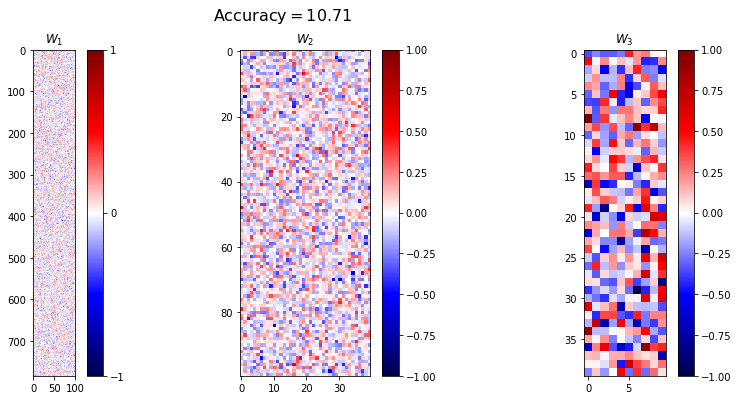

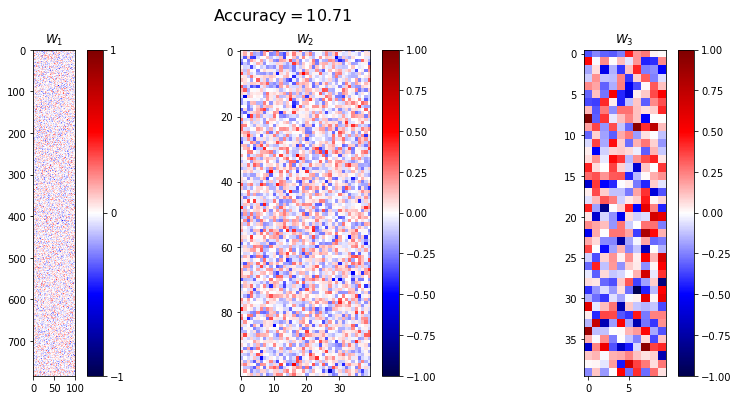

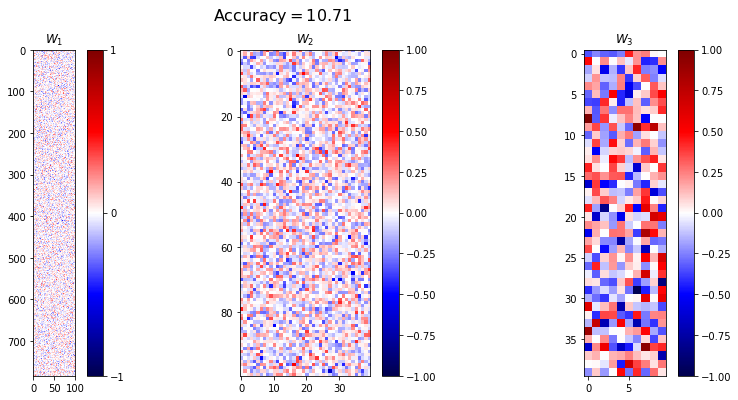

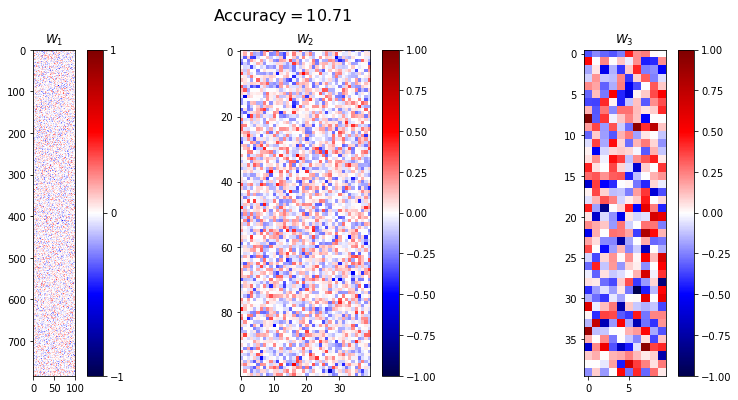

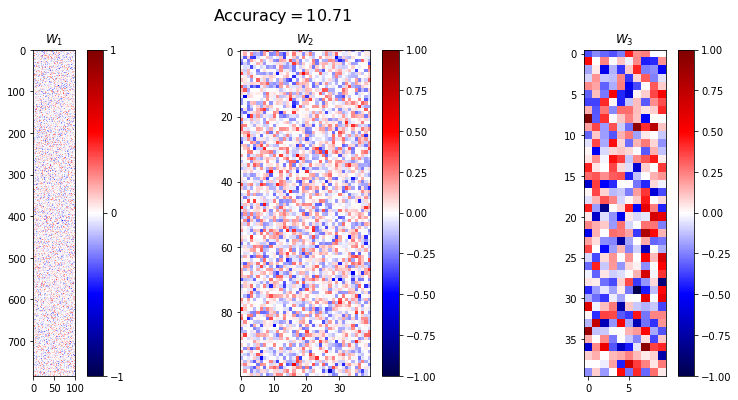

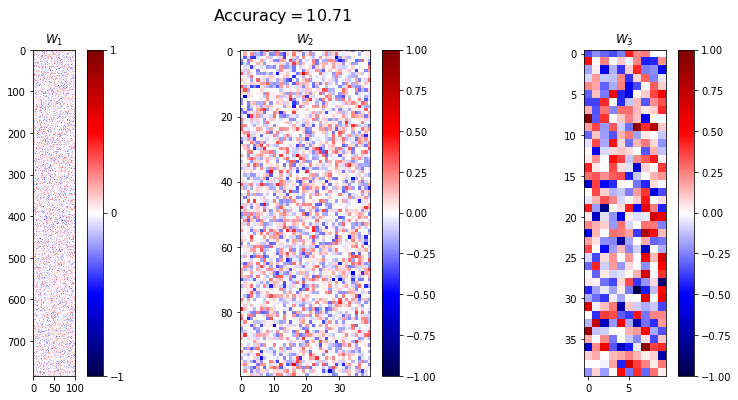

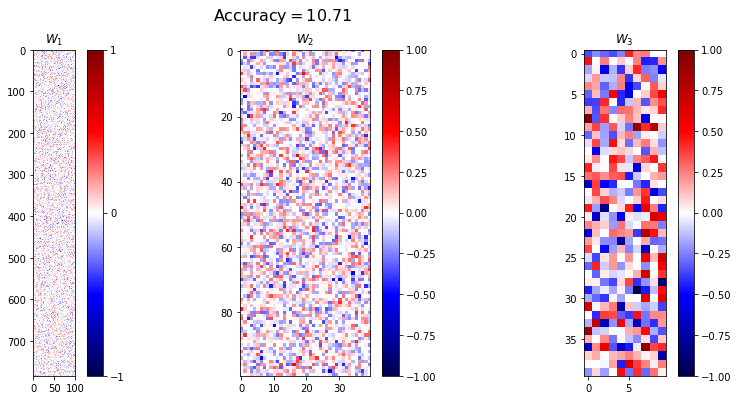

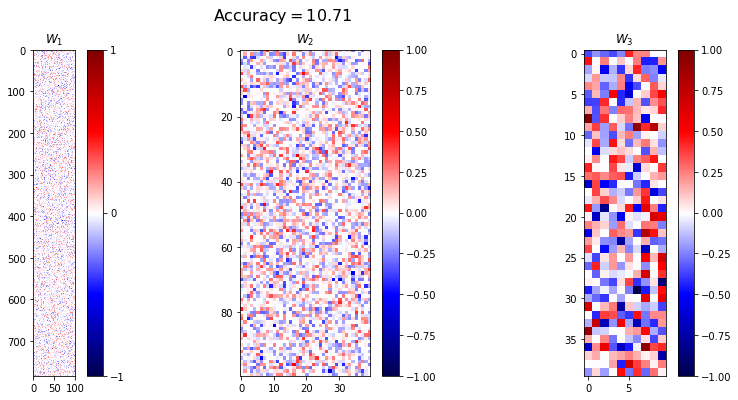

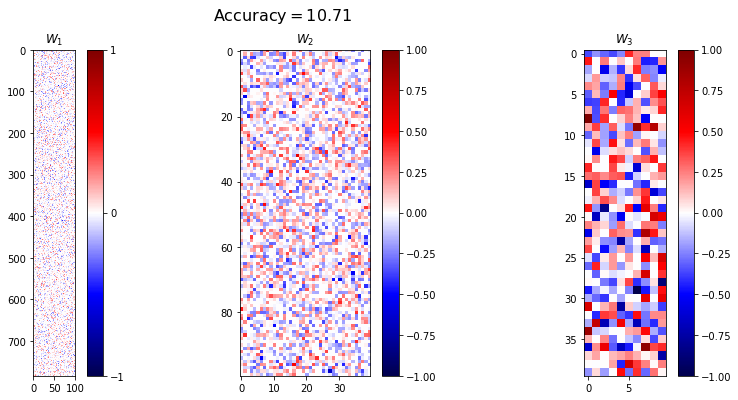

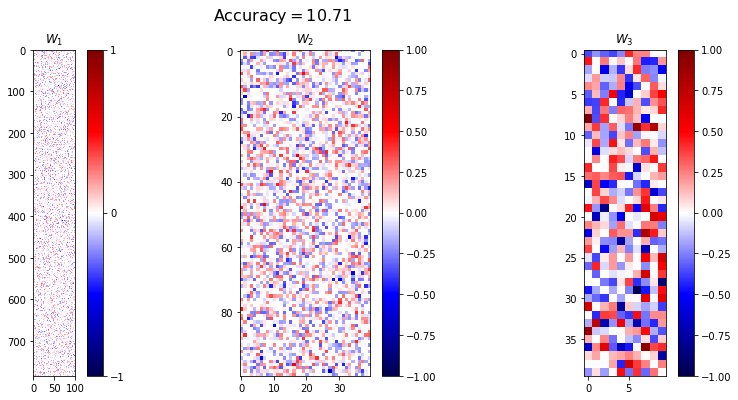

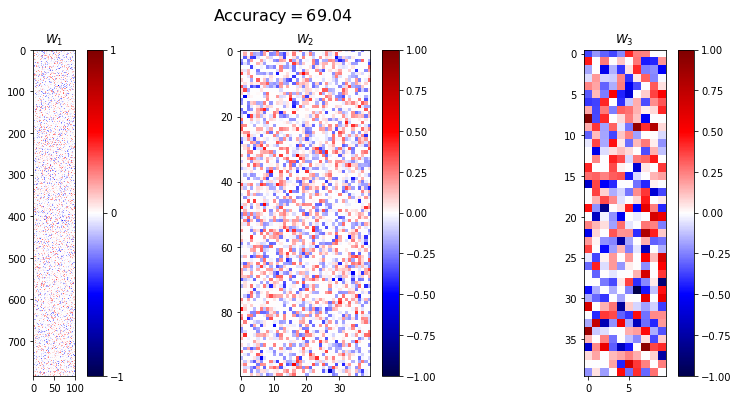

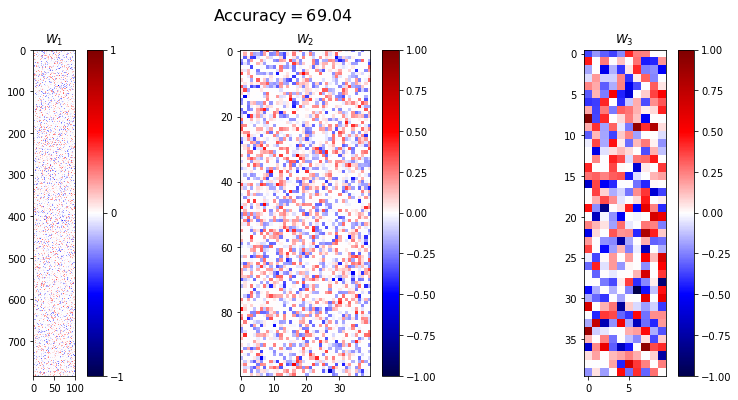

In [ ]:
clf = dropout_fc()
opt = optim.Adam(clf.parameters(), lr=0.0001)
loss_train = np.array([])
loss_test = np.array([])
reg = 1
for k in range(1, 100):
    #if k>5:
    #   reg = 1
    #loss_train = np.append(loss_train, epoch(clf, opt))
    #loss_train = np.append(loss_test, test(clf))
    tst = test(clf)
    epoch(clf, opt, reg, k, tst)
    print(tst)
    #print(test(clf))